In [ ]:
# Week 3 — Energy Prediction Project  

This notebook performs:

- Timestamp creation  
- EDA  
- Feature engineering  
- XGBoost Model  
- LSTM Model  
- Saving outputs  

Run each cell step-by-step.


In [8]:
# Setup: imports and paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

DATA_RAW = Path('data/energy.csv')
DATA_TS = Path('data/energy_with_timestamp.csv')
DATA_FE = Path('data/energy_features.csv')
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("Paths set. Raw data exists:", DATA_RAW.exists())


Paths set. Raw data exists: True


In [9]:
df = pd.read_csv(DATA_RAW)
df.head()


,Temperature,Humidity,Light,CO2,HumidityRatio,EnergyConsumption
0,22.5,45.1,350,800,0.0047,12.5
1,23.2,44.8,370,820,0.0046,13.0
2,21.8,47.3,300,780,0.0049,11.8
3,24.0,43.0,420,850,0.0044,13.5
4,25.1,40.5,480,870,0.0042,14.2


In [ ]:
## 1) Creating Timestamp  
If your CSV has no timestamp column, we generate an hourly sequence.


In [10]:
if 'timestamp' not in df.columns:
    df['timestamp'] = pd.date_range(
        start='2024-01-01 00:00:00',
        periods=len(df),
        freq='H'
    )
else:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

df.to_csv(DATA_TS, index=False)
df.head()


C:\Users\jayshear\AppData\Local\Temp\ipykernel_3376\283665854.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.date_range(


,Temperature,Humidity,Light,CO2,HumidityRatio,EnergyConsumption,timestamp
0,22.5,45.1,350,800,0.0047,12.5,2024-01-01 00:00:00
1,23.2,44.8,370,820,0.0046,13.0,2024-01-01 01:00:00
2,21.8,47.3,300,780,0.0049,11.8,2024-01-01 02:00:00
3,24.0,43.0,420,850,0.0044,13.5,2024-01-01 03:00:00
4,25.1,40.5,480,870,0.0042,14.2,2024-01-01 04:00:00


In [ ]:
## 2) Exploratory Data Analysis (EDA)  
Now we inspect distributions, correlations, and time-series behaviour.


In [11]:
df = pd.read_csv(DATA_TS, parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

print(df.info())
df.describe().T


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2024-01-01 00:00:00 to 2024-01-01 09:00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        10 non-null     float64
 1   Humidity           10 non-null     float64
 2   Light              10 non-null     int64  
 3   CO2                10 non-null     int64  
 4   HumidityRatio      10 non-null     float64
 5   EnergyConsumption  10 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 560.0 bytes
None


,count,mean,std,min,25%,50%,75%,max
Temperature,10.0,23.40000,1.652607,20.900,22.125000,23.4500,24.375000,26.3000
Humidity,10.0,43.88000,3.308508,38.700,41.475000,43.9000,46.375000,49.1000
Light,10.0,389.00000,84.649605,250.000,335.000000,390.0000,450.000000,520.0000
CO2,10.0,828.50000,41.769872,760.000,802.500000,830.0000,861.250000,890.0000
HumidityRatio,10.0,0.00451,0.000367,0.004,0.004225,0.0045,0.004775,0.0051
EnergyConsumption,10.0,13.00000,1.207385,10.900,12.125000,13.1500,13.875000,14.8000


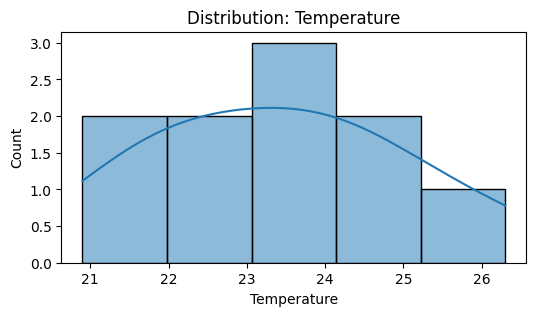

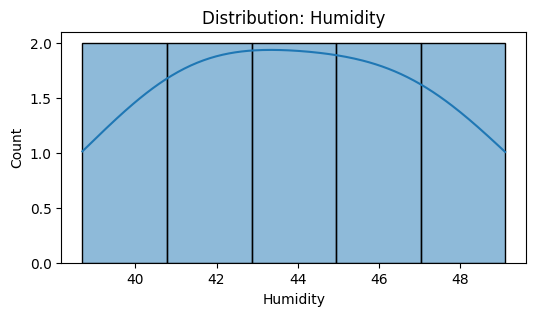

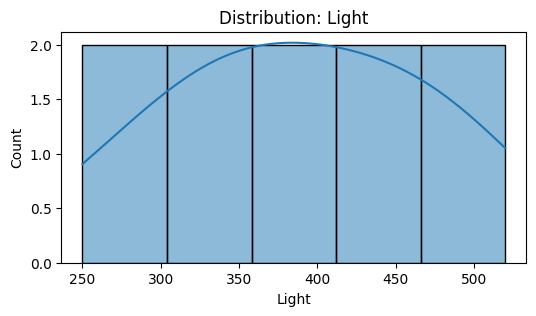

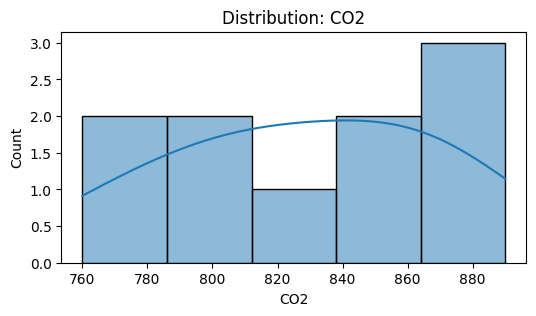

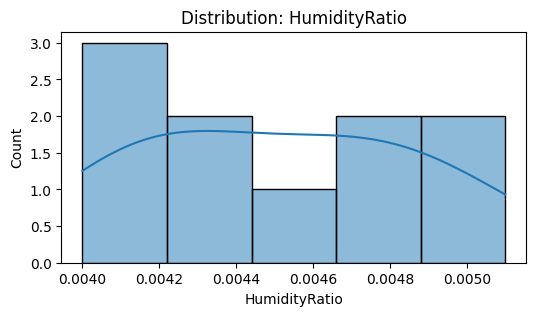

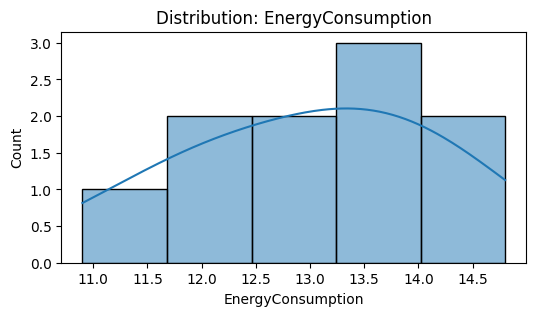

In [12]:
cols = df.columns

for c in cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[c], kde=True)
    plt.title(f'Distribution: {c}')
    plt.show()


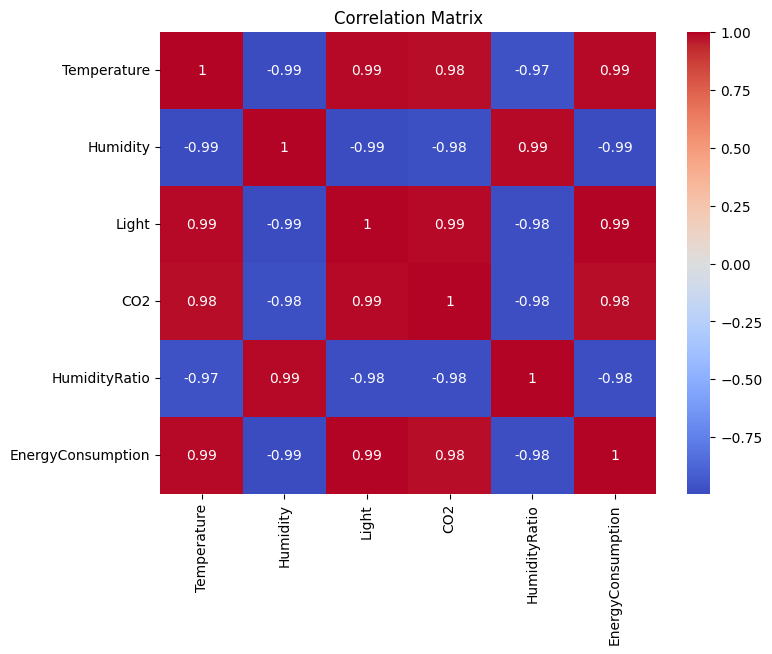

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


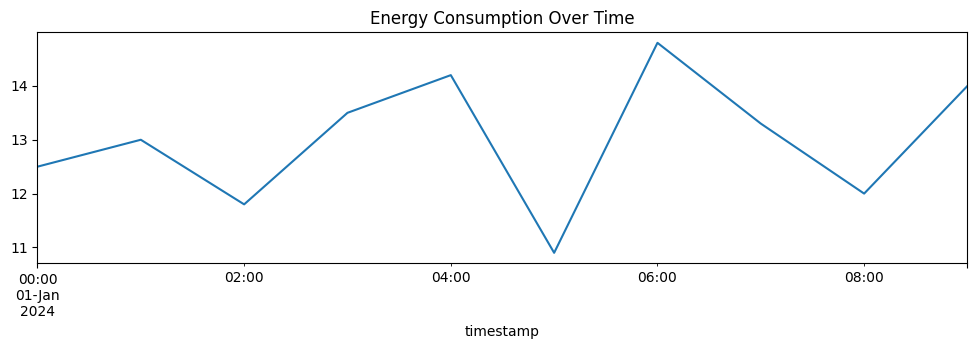

In [14]:
plt.figure(figsize=(12,3))
df['EnergyConsumption'].plot()
plt.title("Energy Consumption Over Time")
plt.show()


In [ ]:
## 3) Feature Engineering  
We add hour, weekday, rolling averages, lag features.


In [15]:
df_fe = df.copy()

df_fe['hour'] = df_fe.index.hour
df_fe['weekday'] = df_fe.index.weekday
df_fe['is_weekend'] = df_fe['weekday'].isin([5,6]).astype(int)

df_fe['rolling_3h'] = df_fe['EnergyConsumption'].rolling(3, min_periods=1).mean()
df_fe['rolling_24h'] = df_fe['EnergyConsumption'].rolling(24, min_periods=1).mean()

df_fe['lag_1'] = df_fe['EnergyConsumption'].shift(1)
df_fe['lag_24'] = df_fe['EnergyConsumption'].shift(24)

df_fe = df_fe.dropna()
df_fe.to_csv(DATA_FE)

df_fe.head()


,Temperature,Humidity,Light,CO2,HumidityRatio,EnergyConsumption,hour,weekday,is_weekend,rolling_3h,rolling_24h,lag_1,lag_24
timestamp,,,,,,,,,,,,,


In [ ]:
## 4) Training XGBoost  
We train a boosted-tree model on engineered features.


In [23]:
# ---------------------------------------------
#  SAFE TRAINING PIPELINE FOR SMALL DATASETS
# ---------------------------------------------
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# ------------ 1. Load raw + create timestamp -------------
RAW = "data/energy.csv"
TS = "data/energy_with_timestamp.csv"
FE = "data/energy_features.csv"

df_raw = pd.read_csv(RAW)

# Use lowercase 'h' (no warning)
if 'timestamp' not in df_raw.columns:
    df_raw['timestamp'] = pd.date_range(
        start='2024-01-01 00:00:00',
        periods=len(df_raw),
        freq='h'
    )

df_raw.to_csv(TS, index=False)

df = pd.read_csv(TS, parse_dates=['timestamp']).set_index('timestamp')

print("Loaded rows:", len(df))
print(df.head())

# ------------ 2. LIGHT Feature Engineering (for tiny datasets) -------------
df_fe = df.copy()

df_fe['hour'] = df_fe.index.hour
df_fe['weekday'] = df_fe.index.weekday
df_fe['is_weekend'] = df_fe['weekday'].isin([5,6]).astype(int)

df_fe['rolling_2h'] = df_fe['EnergyConsumption'].rolling(2, min_periods=1).mean()
df_fe['rolling_3h'] = df_fe['EnergyConsumption'].rolling(3, min_periods=1).mean()

df_fe['lag_1'] = df_fe['EnergyConsumption'].shift(1)

# Clean missing values (modern syntax, no warnings)
df_fe = df_fe.ffill().bfill()

# Save engineered features
df_fe.to_csv(FE)
print("Features saved →", FE)
print(df_fe.tail())

# ------------ 3. Verify data size -------------
n_rows = len(df_fe)
print("\nUsable rows:", n_rows)

if n_rows < 5:
    print("\n⚠️ DATA TOO SMALL for XGBoost. Using persistence baseline instead.")
    values = df_fe['EnergyConsumption'].values.astype(float)
    preds = []
    trues = []
    for i in range(1, len(values)):
        preds.append(values[i-1])
        trues.append(values[i])
    if len(trues) > 0:
        baseline_rmse = np.sqrt(mean_squared_error(trues, preds))
        print("📌 Persistence Baseline RMSE:", baseline_rmse)
    else:
        print("❌ Not enough data even for baseline.")
else:
    # ------------ 4. Train XGBoost (safe split) -------------
    y = df_fe['EnergyConsumption'].astype(float)
    X = df_fe.drop(columns=['EnergyConsumption'])

    split = max(1, int(0.8 * n_rows))
    if split >= n_rows:
        split = n_rows - 1

    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    print("\nTrain rows:", len(X_train), "Test rows:", len(X_test))

    # Train XGB
    xgb = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42,
        verbosity=1
    )

    xgb.fit(X_train, y_train)

    preds = xgb.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("\n🎯 XGBoost RMSE:", rmse)

    # Save model
    joblib.dump(xgb, "models/xgb_model.pkl")
    print("💾 Saved XGBoost → models/xgb_model.pkl")

print("\n✅ DONE")



Loaded rows: 10
                     Temperature  Humidity  Light  CO2  HumidityRatio  \
timestamp                                                               
2024-01-01 00:00:00         22.5      45.1    350  800         0.0047   
2024-01-01 01:00:00         23.2      44.8    370  820         0.0046   
2024-01-01 02:00:00         21.8      47.3    300  780         0.0049   
2024-01-01 03:00:00         24.0      43.0    420  850         0.0044   
2024-01-01 04:00:00         25.1      40.5    480  870         0.0042   

                     EnergyConsumption  
timestamp                               
2024-01-01 00:00:00               12.5  
2024-01-01 01:00:00               13.0  
2024-01-01 02:00:00               11.8  
2024-01-01 03:00:00               13.5  
2024-01-01 04:00:00               14.2  
Features saved → data/energy_features.csv
                     Temperature  Humidity  Light  CO2  HumidityRatio  \
timestamp                                                             

In [24]:
joblib.dump(xgb, MODELS_DIR / 'xgb_model.pkl')
print("Saved XGBoost model → models/xgb_model.pkl")


Saved XGBoost model → models/xgb_model.pkl
